In [1]:
# Add the parent directory of the current working directory to the Python path at runtime. 
# In order to import modules from the src directory.
import os
import sys 

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
import tomllib
import numpy as np
import matplotlib.pyplot as plt

from src.sim_utils import initialize_simulation_classes, setup_parallel_processing, generate_stimulus_conditions, generate_time_index
from src.anl_utils import order_parameter, compute_phase_difference, compute_weighted_locking, expand_matrix

from multiprocessing import Pool, Array

In [3]:
def compute_frequency(contrast, parameters):
    """
    Compute the frequency of the oscillation given the contrast and the parameters of the model.
    """
    # Extract the parameters
    contrast_slope = parameters['contrast_slope']
    contrast_intercept = parameters['contrast_intercept']

    # Compute the frequency
    frequency = contrast_slope * contrast + contrast_intercept
    angular_velocity = 2 * np.pi * frequency
    return frequency, angular_velocity

def load_configuration(filename):
    """
    Load the configuration from a file.
    """
    # Load the configuration
    with open(filename, 'rb') as file:
        configuration = tomllib.load(file)

    # Return the configuration
    return configuration

def run_block(block, experiment_parameters, simulation_parameters,
              stimulus_conditions, simulation_classes, sync_index):
    """
    Run a block of the Arnold tongue. This function is used for parallel processing.

    Parameters
    ----------
    block : int
        The block number.
    experiment_parameters : dict
        The experiment parameters.
    simulation_parameters : dict
        The simulation parameters.
    stimulus_conditions : tuple
        The stimulus conditions.
    simulation_classes : tuple
        The simulation classes.
    indexing : tuple
        The indexing for synchronization.
    """
    global arnold_tongue, locking

    grid_coarseness, contrast_heterogeneity = stimulus_conditions
    model, stimulus_generator = simulation_classes

    np.random.seed(simulation_parameters['random_seed'] + block)

    for condition, (scaling_factor, contrast_range) in enumerate(
            zip(grid_coarseness, contrast_heterogeneity)):
        stimulus = stimulus_generator.generate(
            scaling_factor, contrast_range,
            experiment_parameters['mean_contrast'])
        model.compute_omega(stimulus.flatten())
        state_variables, _ = model.simulate(simulation_parameters)
        synchronization = np.abs(order_parameter(state_variables))
        index = block * experiment_parameters['num_conditions'] + condition
        arnold_tongue[index] = np.mean(synchronization[sync_index])


def run_simulation(experiment_parameters, simulation_parameters,
                   stimulus_conditions, simulation_classes, indexing):
    """
    Run the simulation.

    Parameters
    ----------
    experiment_parameters : dict
        The experiment parameters.
    simulation_parameters : dict
        The simulation parameters.
    stimulus_conditions : tuple
        The stimulus conditions.
    simulation_classes : tuple
        The simulation classes.
    indexing : tuple
        The indexing for synchronization.
        
    Returns
    -------
    arnold_tongue : array_like
        The Arnold tongue.
    """

    global arnold_tongue, locking

    # Initialize the Arnold tongue
    arnold_tongue = np.zeros((experiment_parameters['num_blocks'],
                              experiment_parameters['num_conditions']))
    arnold_tongue = Array('d', arnold_tongue.reshape(-1))

    # Run a batch of blocks in parallel
    for batch in range(simulation_parameters['num_batches']):
        with Pool(experiment_parameters['num_blocks']) as p:
            p.starmap(
                run_block,
                [(block, experiment_parameters, simulation_parameters,
                  stimulus_conditions, simulation_classes,
                  indexing)
                 for block in range(batch * simulation_parameters['num_cores'],
                                    (batch + 1) *
                                    simulation_parameters['num_cores'])])

    # Collect simulation results
    arnold_tongue = np.array(arnold_tongue).reshape(
        experiment_parameters['num_blocks'],
        experiment_parameters['num_conditions'])

    return arnold_tongue

In [4]:
model_config = '../config/simulation/model.toml'
sim_config = '../config/simulation/simulation.toml'
stimulus_config = '../config/simulation/stimulus.toml'
experiment_config = '../config/analysis/experiment_actual.toml'


model_parameters = load_configuration(model_config)
simulation_parameters = load_configuration(sim_config)
stimulus_parameters = load_configuration(stimulus_config)
experiment_parameters = load_configuration(experiment_config)


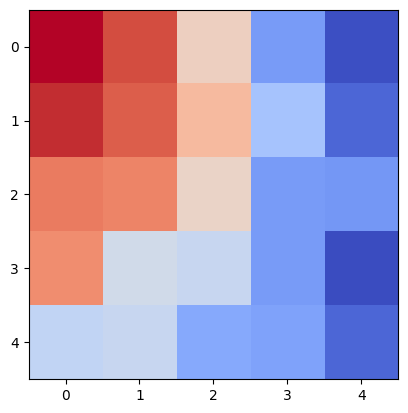

In [25]:
session_1 = '../results/empirical/session_1'
empirical_data = np.load(session_1 + '/average_bat.npy')
plt.imshow(empirical_data, cmap='coolwarm')
empirical_data = empirical_data.flatten()

In [ ]:
session_8 = '../results/empirical/session_8'
empirical_data = np.load(session_8 + '/average_bat.npy')
plt.imshow(empirical_data, cmap='coolwarm')
empirical_data = empirical_data.flatten()

In [6]:
# Set up parallel processing
simulation_parameters, experiment_parameters = setup_parallel_processing(simulation_parameters, experiment_parameters)
simulation_parameters['num_cores'] = 10
# Set up the stimulus conditions
stimulus_conditions = generate_stimulus_conditions(experiment_parameters)
# Set up the synchronization index and timepoint
sync_index, _ = generate_time_index(simulation_parameters)

In [28]:


slopes = np.linspace(0.1, 0.15, 5)
slopes = slopes[1:-1]
print(slopes)
corrs = np.zeros(3)

for i, slope in enumerate(slopes):
    model_parameters['contrast_slope'] = slope

    # Initialize the model and stimulus generator
    simulation_classes = initialize_simulation_classes(model_parameters,
                                                        stimulus_parameters)

    # Run the simulation
    arnold_tongue = run_simulation(experiment_parameters, simulation_parameters,
                                    stimulus_conditions, simulation_classes,
                                    sync_index)

    # Compute the correlation
    corrs[i] = np.corrcoef(arnold_tongue.mean(axis=0), empirical_data)[0, 1]

    print(f'Slope: {slope}, Correlation: {corrs[i]}')


    

[0.1125 0.125  0.1375]
Slope: 0.1125, Correlation: 0.924052703720511
Slope: 0.125, Correlation: 0.9258858661951566
Slope: 0.1375, Correlation: 0.9213744613483682


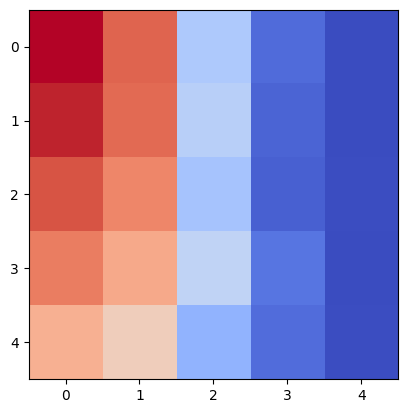

In [29]:
first_session = 'Slope: 0.125, Correlation: 0.9258858661951566'
fourth_session = 'Slope: 0.1, Correlation: 0.9614843824565608'
last_session = 'Slope: 0.1125, Correlation: 0.973724176560302'
AT = arnold_tongue.mean(axis=0).reshape(5, 5)
plt.imshow(AT, cmap='coolwarm')

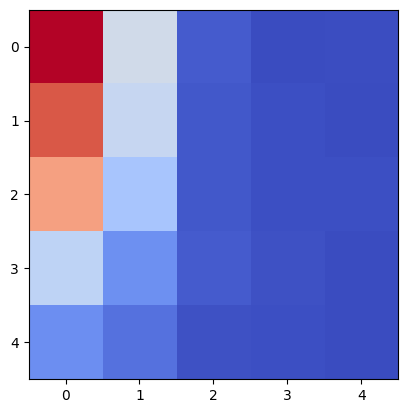

In [30]:
model_parameters['contrast_slope'] = 0.25

# Initialize the model and stimulus generator
simulation_classes = initialize_simulation_classes(model_parameters,
                                                        stimulus_parameters)

# Run the simulation
arnold_tongue = run_simulation(experiment_parameters, simulation_parameters,
                                    stimulus_conditions, simulation_classes,
                                    sync_index)

AT = arnold_tongue.mean(axis=0).reshape(5, 5)
plt.imshow(AT, cmap='coolwarm')